# Variational Quantum Circuits as General Function Generators:




A quantum computer and thus quantum circuits follow unitary transformations which allow us to change the state of quantum bits or qubits. The state of a qubit could be anything on the Bloch sphere and thus the most general transformations allow us to create the most general qubit states.

A quantum circuit can also be used as a machine learning model and can be trained according to a given target function. This is possible due to the presence of parameterized gates which are operators whose parameters can be varied. These gates form a circuit which can be repeatedly measured with different values of the parameters to estimate the expectation of some observable.

Here, we use this property of variational quantum circuits to build General Function Generators of 2D functions which are partially and completely separable.

For an introduction to General Function Generators of 1D functions refer to [this] tutorial.

First, we import the required libraries.
 


In [1]:
import tequila as tq
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Completely Separable Functions:

A completely separable 2D function is one which can be written as a tensor product of two 1D functions i.e.

$$
f(x,y) = (h\otimes g) (x,y) = h(x)g(y)
$$


Here, we will be exploting this property of a completely separable 2D function (e.g. a bell shaped function) to train our circuit. 

## Target Function:

We first construct the 2D target function given by

$$
f(x,y) = exp(-(x^{2} + y^{2}))
$$

In this case $g = h$


In [2]:
def target_function_2D(x, y):
    
    """
    Returns a scaled 2D gaussian function whose values will be used as training points
    
    """
    
    return np.exp(-(x**2 + y**2))


3D Plot of Target Function


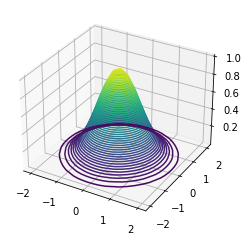

In [3]:
x = np.linspace(-2, 2, 21)
y = np.linspace(-2, 2, 21)
X, Y = np.meshgrid(x, y)

z = target_function_2D(X, Y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, z, 50)
print('3D Plot of Target Function')

Contours Plot of Target Function


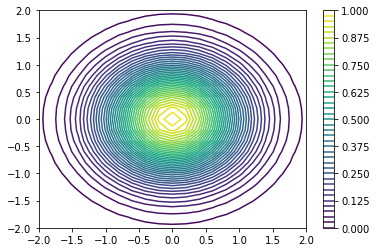

In [4]:
fig,ax=plt.subplots(1,1)
cp = ax.contour(X, Y, z,40)
fig.colorbar(cp)
print('Contours Plot of Target Function')
plt.show()

As the above gaussian is a symmetric function, it can be written as a tensor product of two 1D gaussian function given by:

$$
f(x) = exp(-x^{2})
$$

In [5]:
def target_function_1D(x):
    
    """
    Returns a scaled 1D gaussian function whose values will be used as training points
    
    """
    return np.exp(-(x*x))

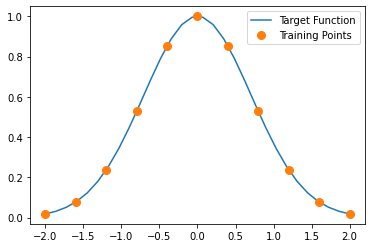

In [19]:
x = np.linspace(-2, 2, 11)
xtest = np.linspace(-2, 2, 30)
f = target_function_1D(xtest)
ftrain = target_function_1D(x)

plt.plot(xtest, f, markersize = 8, label = "Target Function")
plt.plot(x, ftrain, markersize = 8, marker = 'o', linestyle="", label = "Training Points")

plt.legend()
plt.show()

## Objective Function:

For completely separable functions, we will first train our circuit for a 1D function using a single qubit. To get the 2D function we will use the optimized paramters of the variational circuit and construct a 2 qubit circuit. At the end, we will the expectation value obtained for the two individual quibits to get our 2D values.

The single qubit circuit will be of the form:

$$
U = R_{x}(2ax + 2b)R_{y}(2c)
$$

where a, b and c are the variational parameters. The final function will be obtained by 

$$
f(x,y) = \langle Z(0) \rangle _{U1} \cdot \langle Z(1) \rangle _{U2}
$$

where $U1$ and $U2$ are the circuit unitaries applied on qubit 1 and 2 respectively.

In [11]:
def objective_function_1D(x, layers):
    
    """
    Constructs and returns a trainable tequila objective. The objective is the expectation value E = <U|H|U>
    where H is the Pauli z gate and U is the trainable circuit.
    
    """
    

    circuit = tq.QCircuit()
    
    for i in range(layers):
        
        a = tq.Variable(name=("a", i))
        b = tq.Variable(name=("b", i))
        c = tq.Variable(name=("c", i))
        
        circuit += tq.gates.Rx(angle = 2*a*x + 2*b, target = 0)
        circuit += tq.gates.Ry(angle = 2*c, target = 0)
    
    
    H = tq.paulis.Z(0)
    
    E = tq.ExpectationValue(H = H, U = circuit)
    
    return E  


def objective_function_2D(x, y, layers):
    
    """
    Constructs and returns a trainable tequila objective. The objective is the expectation value E = <U|H1|U> * <U|H2|U>
    where H is the Pauli z gate and U is the trainable circuit.
    
    """
    
    
    circuit = tq.QCircuit()
    
    for i in range(layers):
        
        a = tq.Variable(name=("a", i))
        b = tq.Variable(name=("b", i))
        c = tq.Variable(name=("c", i))
        
        circuit += tq.gates.Rx(angle = 2*a*x + 2*b, target = 0)
        circuit += tq.gates.Ry(angle = 2*c, target = 0)
        
        circuit += tq.gates.Rx(angle = 2*a*y + 2*b, target = 1)
        circuit += tq.gates.Ry(angle = 2*c, target = 1)
    
    
    H_0 = tq.paulis.Z(0)
    H_1 = tq.paulis.Z(1)
    
    E = tq.ExpectationValue(H=H_0, U=circuit) * tq.ExpectationValue(H=H_1, U=circuit)
    
    return E

## Cost Function:

We now define the cost function whose value will be minimized by the tequila optimizer during the training step.
It is given as

$$
\text{Cost} = \sum{(\text{objective}\_\text{value}(x) - \text{target}\_\text{value}(x))^{2}}
$$

where the summation is taken over all the values of the input variable $x$

In [12]:
def cost(training_points, layers):
    
    """
    Returns the cost of the training problem in the form 
    of a tequila objective.
    
    """
    
    loss = 0.0
    y = training_points[::2]
    
    for i in y:
        
        loss += (objective_function_1D(i, layers) - target_function_1D(i)).apply(tq.numpy.square)
        
    return loss/len(y)

Before training the variational circuit, we need to initialize the trainable parameters with some values which will be the starting point of the optimization problem. Here, we will be providing random initial values to the parameters.

In [13]:
def init_values(layers):
    
    """
    Returns a dictionary of random initial values for all the trainable variables
    
    """
    
    init = {}
    for i in range(layers):
        
        init[('a',i)] = np.random.random()
        init[('b',i)] = np.random.random()
        init[('c',i)] = np.random.random()
        
    return init

## Training:

We will be using 4 layers of the above mentioned unitary to train the circuit. First, we take some random values for the variational parameters and see what the 1D objective function gives us with those values.

(-1.0, 1.0)

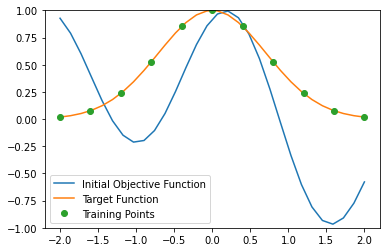

In [22]:
y = []
ftrain = target_function_1D(x)
f = target_function_1D(xtest)
layers = 4
init = init_values(layers)

for i in xtest:
    y.append(tq.simulate(objective_function_1D(i,layers), variables = init))
    
plt.plot(xtest, y, label = "Initial Objective Function")
plt.plot(xtest, f, label = "Target Function")
plt.plot(x, ftrain, label = "Training Points", marker="o", linestyle="")


plt.legend()
plt.ylim(-1,1)

Now we will train the randomly generated values using the tequila optimizer

In [23]:
L = cost(x, layers)
result = tq.minimize(L, initial_values=init)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 6 expectationvalues
gradient        : 216 expectationvalues

active variables : 12

E=+0.38633573  angles= {('a', 0): 0.015498712590010566, ('b', 0): 0.4706290183021933, ('c', 0): 0.42065408727489584, ('a', 1): 0.0752691453397234, ('b', 1): 0.4709501213027609, ('c', 1): 0.32766073076948465, ('a', 2): 0.27749438157527473, ('b', 2): 0.8460079296981141, ('c', 2): 0.5481964169673549, ('a', 3): 0.931864068256584, ('b', 3): 0.8396351381091272, ('c', 3): 0.23010351826764908}  samples= None
E=+0.28455228  angles= {('a', 0): 0.022071827998503622, ('b', 0): 0.8534627755785852, ('c', 0): 0.3583735219403995, ('a', 1): -0.3178268317488828, ('b', 1): 0.6363200901445586, ('c', 1): 0.6586144200358885, ('a', 2): -0.28771812445480305, ('b', 2): 0.8221668636756505, ('c', 2): 0.

E=+0.00000076  angles= {('a', 0): 0.5987462656575823, ('b', 0): 0.9854541779423172, ('c', 0): 0.3071117822478828, ('a', 1): -0.32833248281211397, ('b', 1): 0.3459291836172629, ('c', 1): 0.7520988851918158, ('a', 2): -0.20502592925423224, ('b', 2): 0.8205052985285031, ('c', 2): 0.5145183541365427, ('a', 3): 0.5607545803017859, ('b', 3): 1.266734540118624, ('c', 3): 0.9376682324948411}  samples= None
E=+0.00000012  angles= {('a', 0): 0.5978652887811137, ('b', 0): 0.9849758824180077, ('c', 0): 0.3075236515693311, ('a', 1): -0.32870707360458445, ('b', 1): 0.3449447383244683, ('c', 1): 0.753386714970152, ('a', 2): -0.20458890373712083, ('b', 2): 0.819957018456724, ('c', 2): 0.5145792579986959, ('a', 3): 0.5606727688718949, ('b', 3): 1.2678227212688042, ('c', 3): 0.9382052230787218}  samples= None
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 22
         Gradient evaluations: 22


In [24]:
opt_variables = result.variables

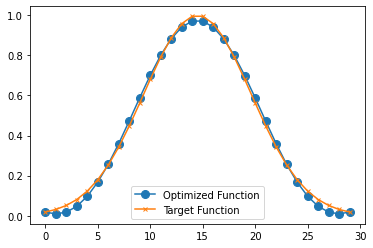

In [26]:
ans = []
target = []
for i in xtest:
    
    f = objective_function_1D(i, layers)
    target.append(target_function_1D(i))
    ans.append(tq.simulate(f,variables=opt_variables))
    
plt.plot(ans, markersize = 8, marker = 'o', label = "Optimized Function")
plt.plot(target, markersize = 4,marker = 'x', label = "Target Function")
plt.legend()

Function optimization results:


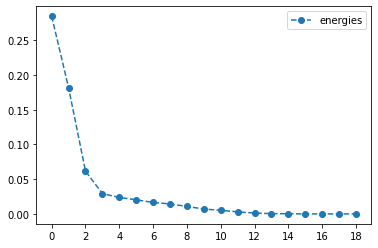

In [27]:
print('Function optimization results:')
result.history.plot('energies')

We can see that the optimized objective function is extremely close to the target function.

We will now construct the 2D function by using the obtained optimized parameters.

In [28]:
ans = []
target = []
for i in xtest:
    for j in xtest:
    
        f = objective_function_2D(i, j, layers)
        target.append(target_function_2D(i, j))
        ans.append(tq.simulate(f,variables = opt_variables))
    

3D Plot of the Optimized Function


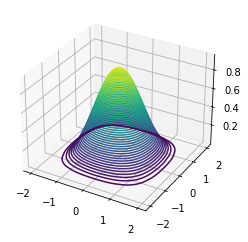

In [31]:
ans = np.reshape(ans, (-1, len(xtest)))
target = np.reshape(target, (-1, len(xtest)))

X, Y = np.meshgrid(xtest, xtest)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, ans, 50)
print('3D Plot of the Optimized Function')

Contours Plot of the Optimized Function


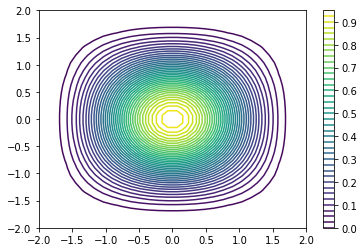

In [32]:
fig,ax=plt.subplots(1,1)
cp = ax.contour(X, Y, ans,40)
fig.colorbar(cp)
print('Contours Plot of the Optimized Function')
plt.show()

To see the difference between the target and the optimized function, we now plot the difference of the values of the two functions

Difference between the optimized and target function


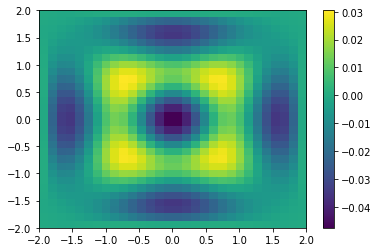

In [33]:
diff = ans - target
plt.imshow(diff, extent=(np.amin(X), np.amax(X), np.amin(Y), np.amax(Y)), aspect = 'auto')
plt.colorbar()
print("Difference between the optimized and target function")
plt.show()

Here, we can see that the errors are extremely small. There are some areas in which comparitively higher error occurs. This is because the 1D gaussian (though nearly perfect) was not optimized completely i.e. the final cost value over all the points was close to 0 but not equal to it.

# Part 2: Partially Separable Functions:

Here we will be using a function which is slightly deviated from the traditional gaussian function. We will be adding a weighted supplementary function to the gaussian function i.e.

$$
f(x,y) = \text{Gaussian}(x,y) + c f'(x,y)
$$

where c is the weight of the supplementary function.

## Target Function:

We will be using the target_function_1D(x) from Part 1 to construct the initial gaussian function. The supplementary function that we will be using in this example is the exponential function

$$
f'(x,y) = exp(-|x-y|)
$$

Here, $f'(x,y)$ is not a separable function i.e. it cannot be written as a tensor product of two simpler functions.


In [34]:
def target_exp_function_2D(x, y, weight):
    
    """
    Returns a scaled 2D gaussian function + weighted supplementary function whose 
    values will be used as training points
    
    """
    
    return np.exp(-(x**2 + y**2)) + weight * np.exp(-np.abs(x-y))

3D Plot of Target Function


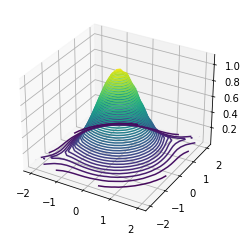

In [35]:
x = np.linspace(-2, 2, 21)
y = np.linspace(-2, 2, 21)
c = 0.1
X, Y = np.meshgrid(x, y)

z = target_exp_function_2D(X, Y, c)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, z, 50)
print('3D Plot of Target Function')

Contours Plot of Target Function


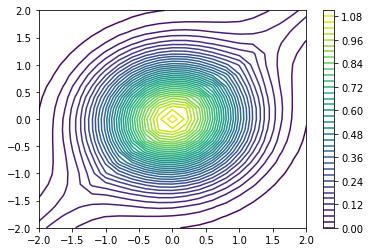

In [36]:
fig,ax=plt.subplots(1,1)
cp = ax.contour(X, Y, z,40)
fig.colorbar(cp)
print('Contours Plot of Target Function')
plt.show()

## Objective Function:

The objective for the 1D objective will the same function that was used in Part 1. For the 2D function, we will need to introduce some entangling gates in the objective to reach an unseparable function. 

The final expecation value of the 2D objective will be calculated by

$$
f(x,y) = \langle Z(0) \rangle _{U} \cdot \langle Z(1) \rangle _{U}
$$

where U is the unitary circuit on both the qubits. 

Here, the unitary $U$ is different from the one used in Part 1 because instead of acting only on a single qubit, it acts on both the qubits of the quantum circuit i.e. the new unitary has some 2-qubit gates which entangle the two qubits. This can be represented as follows:

<div>
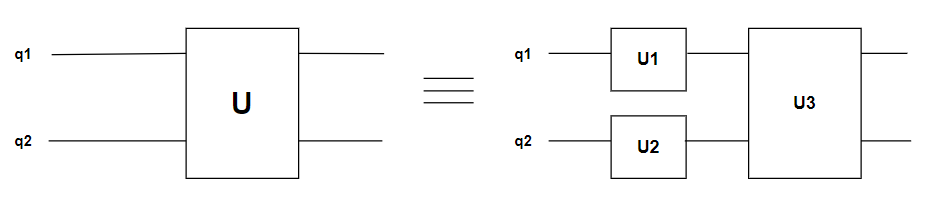
</div>

The $U_{3}$ unitary gate is the entangling 2-qubit gate and we will be using CNOT gates for this purpose.

The starting point of the 2D function training will be the coefficients obtained by training the 1D function in Part 1.


In [37]:
def objective_exp_function_2D(x, y, layers, weight):
    
    """
    Constructs and returns a trainable tequila objective. The objective is the expectation value E = <U|H1|U> * <U|H2|U>
    where H is the Pauli z gate and U is the trainable circuit.
    
    """    

    circuit = tq.QCircuit()
    
    for i in range(layers):
        
        a = tq.Variable(name=("a", i))
        b = tq.Variable(name=("b", i))
        c = tq.Variable(name=("c", i))
        d = tq.Variable(name=("d", i))
        e = tq.Variable(name=("e", i))
        
        circuit += tq.gates.Rx(angle = 2*a*x + 2*b, target = 0)
        circuit += tq.gates.Ry(angle = 2*c, target = 0)
        
        circuit += tq.gates.Rx(angle = 2*a*y + 2*b, target = 1)
        circuit += tq.gates.Ry(angle = 2*c, target = 1)
        
        circuit += tq.gates.Rx(angle = weight, target = 0)
        circuit += tq.gates.Rx(angle = weight, target = 1)
        
        circuit += tq.gates.X(target = 1, control = 0) 
        
        circuit += tq.gates.Ry(angle = d, target = 0)
        circuit += tq.gates.Ry(angle = e, target = 1)
        
        circuit += tq.gates.X(target = 1, control = 0) 
        
        circuit += tq.gates.Rx(angle = weight, target = 0)
        circuit += tq.gates.Rx(angle = weight, target = 1)
    
    
    H_0 = tq.paulis.Z(0)
    H_1 = tq.paulis.Z(1)
    
    E = tq.ExpectationValue(H=H_0, U=circuit) * tq.ExpectationValue(H=H_1, U=circuit)
    
    return E

## Cost Function:

The cost function will be similar to what was defined earlier


In [38]:
def cost_exp(training_points_x, training_points_y, layers, weight):
    
    """
    Returns the cost of the training problem in the form 
    of a tequila objective.
    
    """   


    loss = 0.0
    x = training_points_x[::4]
    y = training_points_y[::4]

    for i in x:
        for j in y:
        
            loss += (objective_exp_function_2D(i,j,layers,weight) - target_exp_function_2D(i,j,weight)).apply(tq.numpy.square)
        
    return loss/(len(x)*len(y))

The initialization function takes the values of the optimal variables obtained in Part 1 and introduces only a small amount of perturbation to them. This moves the starting point away from the local minima of Part 1 by a small amount allowing the objective to reach a minima relevant to the new model.

In [39]:
def init_values_exp(layers, opt_variables):
    
    """
    Returns a dictionary of random initial values for all the trainable variables
    
    """
    
    init = {}
    
    for i in range(layers):
        
        init[('a',i)] = opt_variables[('a',i)] + 0.01 * np.random.random()
        init[('b',i)] = opt_variables[('b',i)] + 0.01 * np.random.random()
        init[('c',i)] = opt_variables[('c',i)] + 0.01 * np.random.random()
        init[('d',i)] = 0.01 * np.random.random()
        init[('e',i)] = 0.01 * np.random.random()
        
    return init

# Training:

We will be using 4 layers of the above mentioned unitary to train the circuit. The value of the weight of the supplementary function in this example will be 0.1

In [41]:
y = np.linspace(-2, 2, len(x))
layers = 4
weight = 0.1
init = init_values_exp(layers, opt_variables)

Now we will train the parameters using the tequila optimizer

In [42]:
L = cost_exp(x, y, layers, weight)
result = tq.minimize(L, initial_values = init)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 18 expectationvalues
gradient        : 1512 expectationvalues

active variables : 20

E=+0.02157171  angles= {('a', 0): 0.6040366415856905, ('b', 0): 0.9922489355514065, ('c', 0): 0.31730073917377843, ('d', 0): 0.00880557392777111, ('e', 0): 0.009168733485444122, ('a', 1): -0.3208084367059302, ('b', 1): 0.34824154424011916, ('c', 1): 0.7632775941310871, ('d', 1): 0.002299574690678068, ('e', 1): 0.0025420344271741635, ('a', 2): -0.19789161159105023, ('b', 2): 0.8250762410658419, ('c', 2): 0.5194429164701029, ('d', 2): 0.002036582752541716, ('e', 2): 0.006332262737430305, ('a', 3): 0.5611482108279959, ('b', 3): 1.2697319359777723, ('c', 3): 0.9428269805365781, ('d', 3): 0.005680225555402434, ('e', 3): 0.0043246851338451025}  samples= None
E=+0.23135686  angles=

E=+0.00129203  angles= {('a', 0): 0.5493148063617772, ('b', 0): 1.0113837681291333, ('c', 0): 0.32652034334727503, ('d', 0): 0.0040431559854622445, ('e', 0): 0.0841731515998912, ('a', 1): -0.3220891791611723, ('b', 1): 0.3019483097656973, ('c', 1): 0.8609332570953633, ('d', 1): 0.016455350484125452, ('e', 1): -0.025841702052377066, ('a', 2): -0.19806520287789012, ('b', 2): 0.7878820215535607, ('c', 2): 0.4365557581108348, ('d', 2): -0.016979473733196002, ('e', 2): 0.03841523537160006, ('a', 3): 0.5309869398908633, ('b', 3): 1.3106141648539846, ('c', 3): 0.9262795231122661, ('d', 3): 0.10843591090657678, ('e', 3): -0.021527788318295375}  samples= None
E=+0.00124883  angles= {('a', 0): 0.5428688153447049, ('b', 0): 1.0114039249982645, ('c', 0): 0.33061925436609374, ('d', 0): 0.007750907950251643, ('e', 0): 0.09060593101563967, ('a', 1): -0.32297191237644135, ('b', 1): 0.3005594925142835, ('c', 1): 0.8660592692826814, ('d', 1): 0.013371834963162714, ('e', 1): -0.02865092404693432, ('a', 2

E=+0.00042045  angles= {('a', 0): 0.4498420985235181, ('b', 0): 1.064936062570816, ('c', 0): 0.3671204737143644, ('d', 0): 0.0731829631841903, ('e', 0): 0.1596093361782003, ('a', 1): -0.4012635132880865, ('b', 1): 0.3282156565358707, ('c', 1): 0.9069776710296766, ('d', 1): 0.03985579172423117, ('e', 1): -0.0015038408894144477, ('a', 2): -0.21896862405353304, ('b', 2): 0.7970180181421899, ('c', 2): 0.44068128272234625, ('d', 2): 0.008078390282379645, ('e', 2): 0.1141716770798783, ('a', 3): 0.5010598893736228, ('b', 3): 1.3535540806455946, ('c', 3): 0.9637362377556681, ('d', 3): 0.18598297045683534, ('e', 3): -0.11236425254359791}  samples= None
E=+0.00033482  angles= {('a', 0): 0.42493641650037867, ('b', 0): 1.0722054756533048, ('c', 0): 0.38091531530275397, ('d', 0): 0.10618209215032123, ('e', 0): 0.20931767858296016, ('a', 1): -0.4171390017239708, ('b', 1): 0.32531491114129557, ('c', 1): 0.917201330778811, ('d', 1): 0.03842574017345121, ('e', 1): 0.010957826241660326, ('a', 2): -0.221

In [43]:
opt_variables_exp = result.variables

In [45]:
ans = []
target = []

for i in xtest:
    for j in xtest:
    
        f = objective_exp_function_2D(i, j, layers, weight)
        target.append(target_exp_function_2D(i, j, weight))
        ans.append(tq.simulate(f, variables = opt_variables_exp))

3D Plot of the Optimized Function


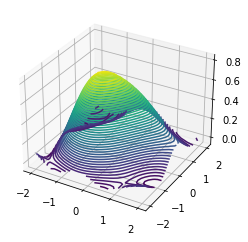

In [47]:
ans = np.reshape(ans, (-1, len(xtest)))
target = np.reshape(target, (-1, len(xtest)))

X, Y = np.meshgrid(xtest, xtest)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.contour3D(X, Y, ans, 50)
print('3D Plot of the Optimized Function')

Contours Plot of the Optimized Function


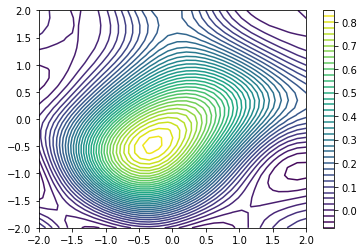

In [48]:
fig,ax=plt.subplots(1,1)
cp = ax.contour(X, Y, ans,40)
fig.colorbar(cp)
print('Contours Plot of the Optimized Function')
plt.show()

Function optimization results:


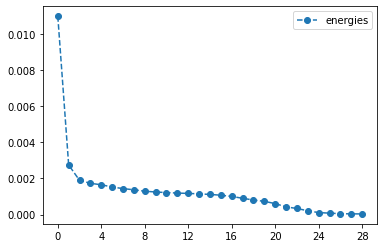

In [49]:
print('Function optimization results:')
result.history.plot('energies')

To see the difference between the target and the optimized function, we now plot the difference of the values of the two functions

Difference between the optimized and target function


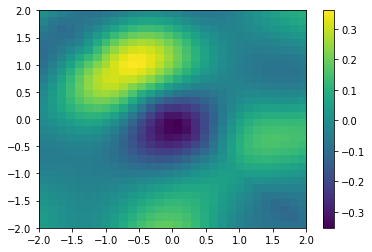

In [50]:
diff = ans - target
plt.imshow(diff, extent=(np.amin(X), np.amax(X), np.amin(Y), np.amax(Y)), aspect = 'auto')
plt.colorbar()
print("Difference between the optimized and target function")
plt.show()

We can see that the objective function was almost able to reach the target function. Relatively higher errors are present because the optimization started from values which were not completely optimized i.e. the final cost value of the 1D gaussian was close to 0 but not equal to it. Also, the set of training points in this particular example was smaller than the total set which could also lead to relatively larger errors.

<b>NOTE:</b> The results will vary due to the random initialization of the trainable parameters and the choice of the optimizer/threshold values. For more information about the workings of the tequila optimizer kindly refer to the [optimizer tutorial](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/Optimizer_Tutorial.ipynb) which covers the usage of different optimizers available in tequila.